# **Hotel Booking Cancellation Classification**

## Abstract 

In tourism and travel related industries, most of the research on Revenue Management demand forecasting and prediction problems employ data from the aviation industry, in the format known as the Passenger Name Record (PNR). This is a format developed by the aviation industry. Hence, two hotel datasets with demand data are shared to help in overcoming this limitation.

Data source : [Science Direct (Hotel Booking)](https://www.sciencedirect.com/science/article/pii/S2352340918315191 'Click to visit')

## Problem Statement

Booking cancellations is undoubtley a biggest problem for a Hotel Manager. So, we as a Revenue Manager are going to study the case and figure out the important factor causing the cancellations.

+ Average rate of individual
+ Active reservation month
+ Duration of stay
+ Market segment distribution
+ Rate of cancellation
+ Seasonal effect on cancellation
+ Customer classification
+ Effect of lead_time

*We have dataset containing the hotel booking data arrived between July 2015 and August 2017.*

## Loading Dependencies

In [1]:
# data analysis tools
import pandas as pd
import numpy as np

# model development and evaluation tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, plot_precision_recall_curve, f1_score

# data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# configurations
import warnings
pd.set_option("display.max_columns", 0)
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
# code to read dataset
df = pd.read_csv("data/hotel_bookings.csv")
display(df.shape) # checking the dimension and length of dataset
df.head()

(119390, 32)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### Missing Value Imputation

Function to check missing value in the dataset.

In [3]:
# block of code to find missing data
def find_nulls(*, data):
    missing_data = df.isna().sum()
    return dict(missing_data[missing_data>0])

In [4]:
for col in find_nulls(data=df).keys():
    print(f'{col.upper()} : {df[col].nunique()} unique items listed below.')
    print(f'Missing count : {df[col].isna().sum()}')
    print(df[col].unique(), '\n')

CHILDREN : 5 unique items listed below.
Missing count : 4
[ 0.  1.  2. 10.  3. nan] 

COUNTRY : 177 unique items listed below.
Missing count : 488
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA'
 'KHM' 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA

Null values impuation

In [5]:
nan_replacements = {
    "country": df["country"].mode()[0],
    "agent": df["agent"].mode()[0],
    "company": df["company"].mode()[0]
}
hotel_book = df.fillna(nan_replacements)
hotel_book.dropna(inplace=True)

Filtering the dataset with atleast one guest!

In [6]:
drop_ind = list(hotel_book[hotel_book["adults"] + hotel_book["children"] + hotel_book["babies"] == 0 ].index)

hotel_book = hotel_book.drop(hotel_book.index[drop_ind])

Filtering the dataset with atleast one night stay!

In [7]:
hotel_book.shape

(119206, 32)

In [8]:
drop_ind = list(hotel_book[hotel_book["stays_in_weekend_nights"] + hotel_book["stays_in_week_nights"] == 0 ].index)

df = hotel_book.drop(hotel_book.index[drop_ind])

## Exploratory Data Analysis

In [9]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.000000,118496.00000
mean,0.372443,104.302702,2016.157398,27.162216,15.800179,0.927972,2.502658,1.857177,0.104063,0.007907,0.031782,0.087564,0.136950,0.220328,75.987915,48.414748,2.329893,101.956887,0.062264,0.57072
std,0.483458,106.948904,0.707726,13.588292,8.782556,0.998899,1.908496,0.579339,0.398887,0.097290,0.175419,0.847359,1.499977,0.650179,106.285421,46.462089,17.637500,50.534069,0.244861,0.79267
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.00000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,40.000000,0.000000,69.500000,0.000000,0.00000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,40.000000,0.000000,95.000000,0.000000,0.00000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,40.000000,0.000000,126.000000,0.000000,1.00000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.00000


Through data summary we can see the presence of outlier in `adr`

We can see a negative entry in `adr` column, `adr` Average Daily Rate cannot be negative, Therefore we are going to drop that column

In [10]:
df[df["adr"]>1000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12.0,40.0,0,Transient,5400.0,0,0,Canceled,2016-02-19


In [11]:
df = df[df["adr"]<1000]

In [12]:
(df.adr < 0).value_counts()

False    118494
True          1
Name: adr, dtype: int64

So, there's only one negative entry!

In [13]:
df = df[~(df['adr']<0)]
df.reset_index(drop=True, inplace=True)
df.shape

(118494, 32)

### Feature Analysis 

Before starting with complex analysis we will list out the number of records we have booking cancellation and check-in's for both City Hotel and Resort Hotel Type.

Let's start with plotting Hotel Type Distribution, we are going to use pie data as it is effective to list out qunatitative records and easy to understand with visualization.

#### Hotel Distribution by Cancellation Status

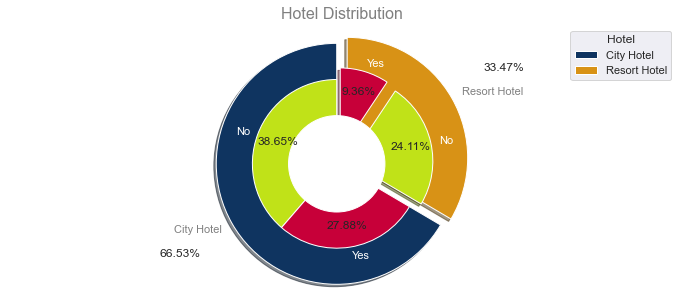

In [14]:
plt.figure(figsize=(12,5))

# plot data
outer_pie_data = df[['hotel']].value_counts().to_frame("counts")
inner_pie_data = df[['hotel', 'is_canceled']].value_counts().to_frame("counts")

# outer pie plot
pie_1 = plt.pie("counts", data=outer_pie_data, colors=["#0F3460", "#D89216"], explode=[0, 0.1], 
             shadow= True, labels=['City Hotel', 'Resort Hotel'], autopct='%1.2f%%', 
             pctdistance=1.5, startangle = 90)
plt.legend(title = "Hotel", loc=1, frameon=True)

# inner pie plot
pie_2 = plt.pie("counts", data=inner_pie_data, colors=["#C0E218", "#C70039"], explode=[0, 0, 0.1, 0.1], 
             shadow= True, labels=['No', 'Yes', 'No', 'Yes'], radius=0.70, autopct='%1.2f%%', 
             pctdistance=0.75, startangle = 90)

# white circle at center
centre_circle = plt.Circle((0,0), 0.4, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

for text in pie_1[1]: text.set_color('grey')
for text in pie_2[1]: text.set_color('white')
    
plt.title("Hotel Distribution", fontsize=16, color="grey")
plt.axis('equal')

plt.savefig("graphs/figure1.png")
plt.show()

In [15]:
df[['hotel', 'is_canceled']].value_counts().to_frame("counts")

counts
hotel        is_canceled        
City Hotel   0             45793
             1             33036
Resort Hotel 0             28569
             1             11096

| Hotel | Cancellation Ratio(%) |
|:---|:---:|
| Total Cancellation | 37.05% |
| City Hotel | 41.72% |
| Resort Hotel | 27.76% |

#### Average Price Per Room types


In [16]:
res_htl = df[(df['hotel']=='Resort Hotel') & (df['is_canceled']==0)]
cty_htl = df[(df['hotel']=='City Hotel') & (df['is_canceled']==0)]

res_htl["adr_pp"] = res_htl["adr"] / (res_htl["adults"] + res_htl["children"])
cty_htl["adr_pp"] = cty_htl["adr"] / (cty_htl["adults"] + cty_htl["children"])

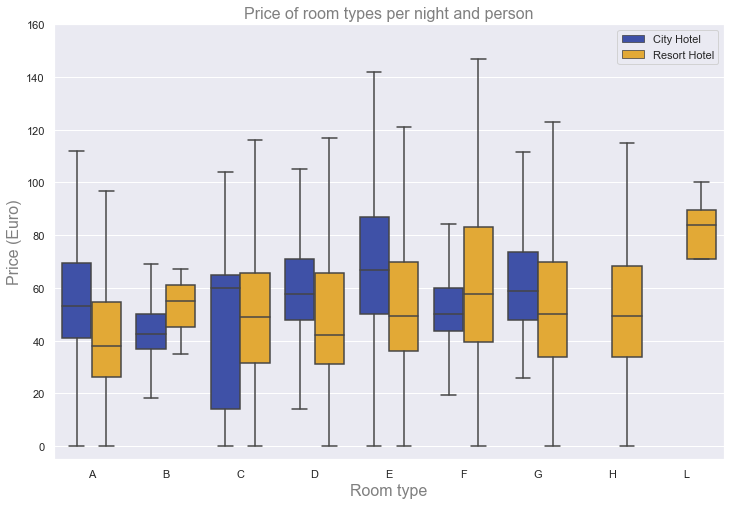

In [17]:
df["adr_pp"] = df["adr"] / (df["adults"] + df["children"])
box_data = df.loc[df["is_canceled"] == 0][["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")

plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type", y="adr_pp", hue="hotel", data=box_data, hue_order=["City Hotel", "Resort Hotel"],
            palette=["#2D46B9", "#FFB319"], fliersize=0)
plt.title("Price of room types per night and person", fontsize=16, color="grey")
plt.xlabel("Room type", fontsize=16, color="grey")
plt.ylabel("Price (Euro)", fontsize=16, color="grey")

plt.legend(loc="upper right")
plt.ylim(-5, 160)
plt.savefig('graphs/figure2.png')
plt.show()

In [18]:
# median rate per person
df['adr_pp'].median()

49.5

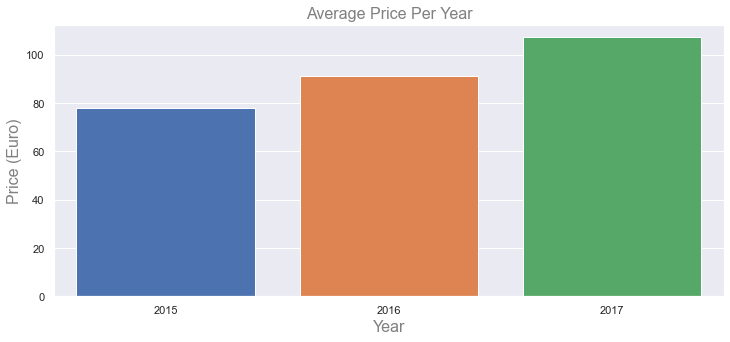

In [19]:
adr_yr = df.groupby('arrival_date_year').adr.median()

plt.figure(figsize=(12, 5))

sns.barplot(x=adr_yr.index.values, y=adr_yr.values, saturation=1)
plt.title("Average Price Per Year", fontsize=16, color="grey")
plt.xlabel("Year", fontsize=16, color="grey")
plt.ylabel("Price (Euro)", fontsize=16, color="grey")

plt.savefig('graphs/figure3.png')
plt.show()

<div class="alert alert-block alert-info">
    
<b>~50 Euros is the Average Daily Rate for Individuals.</b>

| Yearr | ADR PP |
|:---|:---:|
| 2015 | 78.065 |
| 2016 | 91.000 |
| 2017 | 107.100 |
    
</div>

Let's have look over trends when does the hotel has max booking and cancellation

#### Reservation Trends

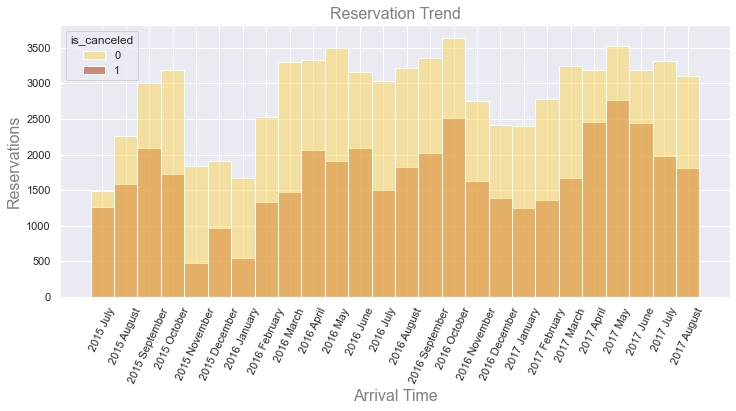

In [20]:
df['arrival_month_year'] = df["arrival_date_year"].astype(str) + " " + df["arrival_date_month"].astype(str)

plt.figure(figsize=(12,5))

hist = sns.histplot(x='arrival_month_year', hue='is_canceled', data=df, palette='afmhot_r')
plt.title("Reservation Trend", fontsize=16, color="grey")
plt.xlabel("Arrival Time", fontsize=16, color="grey")
plt.ylabel("Reservations", fontsize=16, color="grey")
plt.xticks(rotation=65)

plt.savefig('graphs/figure4.png')
plt.show()

We can look over the above plot where we can find some seasonal effects. Lets make it more clear with cancellation ratio data, which we are going to plot next.

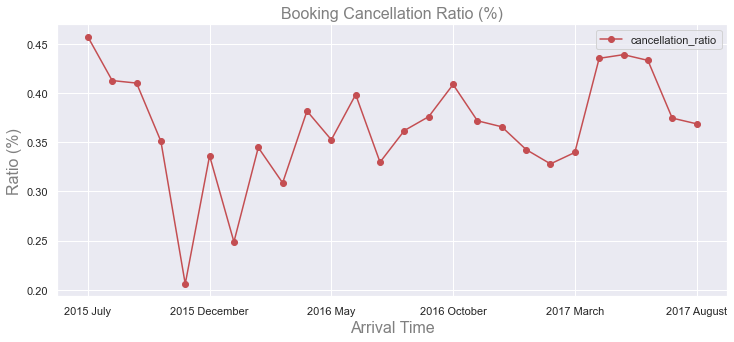

In [21]:
line_data = {}
for duration in df['arrival_month_year'].unique():
    checked_in = len(df[(df['arrival_month_year']==duration) & (df['is_canceled']==0)])
    cancelled = len(df[(df['arrival_month_year']==duration) & (df['is_canceled']==1)])
    cancellation_ratio = cancelled/(checked_in+cancelled)
    line_data[duration] = cancellation_ratio
line_data = pd.DataFrame({'arrival_month_year': line_data.keys(), 'cancellation_ratio': line_data.values()})

line_data.set_index('arrival_month_year', inplace=True)

line_data.plot(kind='line', marker='o', color='r', figsize=(12,5))

plt.title("Booking Cancellation Ratio (%)", fontsize=16, color="grey")
plt.xlabel("Arrival Time", fontsize=16, color="grey")
plt.ylabel("Ratio (%)", fontsize=16, color="grey")

plt.savefig("graphs/figure5.png")
plt.show()

Through both previous trends and cancellation ratio we can see that most booking were cancelled in summer and somehere also in the start of monsoon, and in comparision to them winter was the season with least booking cancellation.

#### Market Segment Distribution

Let's have a look to the market segments and their distribution for checked in as well as cancellation order.

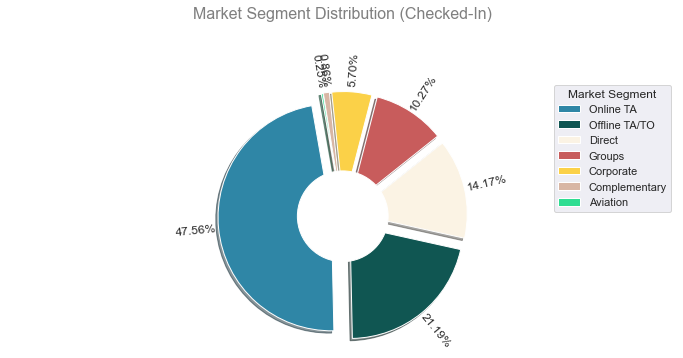

In [22]:
plt.figure(figsize=(12,5))


mark_seg_checked_in = df[(df['is_canceled']==0)]['market_segment'].value_counts().to_frame('counts')

pie_1 = plt.pie("counts", data=mark_seg_checked_in, colors=["#2F86A6", "#105652", "#FBF3E4", "#C85C5C", "#FBD148", "#D8B6A4", "#2FDD92", "#F2F013"], explode=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
             shadow= True, 
                autopct='%1.2f%%', 
             pctdistance=1.2, startangle = 100, rotatelabels=270)

for label, pct_text in zip(pie_1[1], pie_1[2]):
    pct_text.set_rotation(label.get_rotation())
plt.legend(title = "Market Segment", labels=mark_seg_checked_in.index.values, loc=1, frameon=True)

# white circle at center
centre_circle = plt.Circle((0,0), 0.4, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
    
plt.title("Market Segment Distribution (Checked-In)", fontsize=16, color="grey", y=1.2)
plt.axis('equal')

plt.savefig("graphs/figure6.png")
plt.show()

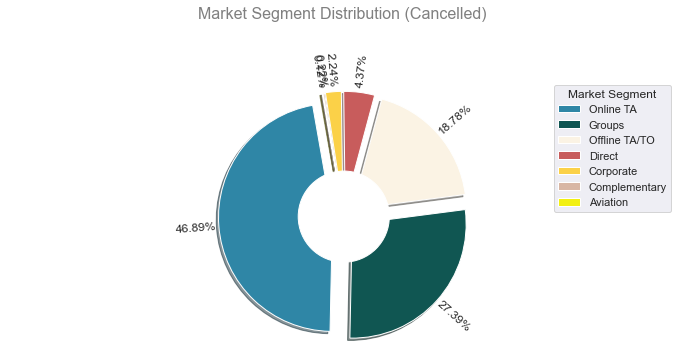

In [23]:
plt.figure(figsize=(12,5))

mark_seg_cancelled = df[(df['is_canceled']==1)]['market_segment'].value_counts().to_frame('counts')

pie_2 = plt.pie("counts", data=mark_seg_cancelled, colors=["#2F86A6", "#105652", "#FBF3E4", "#C85C5C", "#FBD148", "#D8B6A4", "#F2F013"], explode=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
             shadow= True, 
                autopct='%1.2f%%', 
             pctdistance=1.2, startangle = 100, rotatelabels=270)

for label, pct_text in zip(pie_2[1], pie_2[2]):
    pct_text.set_rotation(label.get_rotation())
plt.legend(title = "Market Segment", labels=mark_seg_cancelled.index.values, loc=1, frameon=True)

# white circle at center
centre_circle = plt.Circle((0,0), 0.4, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
    
plt.title("Market Segment Distribution (Cancelled)", fontsize=16, color="grey", y=1.2)
plt.axis('equal')

plt.savefig("graphs/figure7.png")
plt.show()

We have nice insights above where we can see that the most booking was done Online (TA) through Travel Agent and also the most cancellation was done through same.

#### ADR by Market Segment

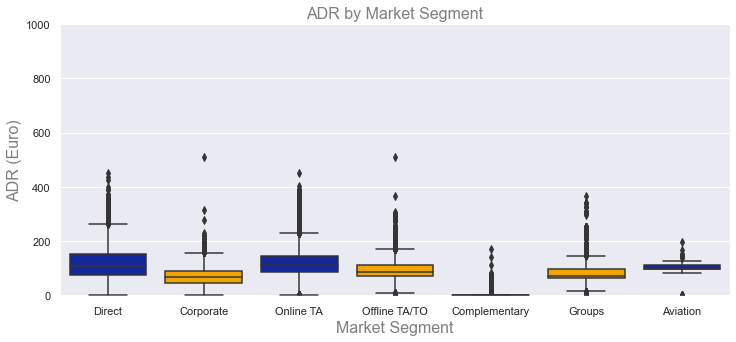

In [24]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='market_segment', y='adr', palette=["#14279B", "#F0A500"], saturation=1)
plt.title("ADR by Market Segment", fontsize=16, color="grey")
plt.xlabel("Market Segment", fontsize=16, color="grey")
plt.ylabel("ADR (Euro)", fontsize=16, color="grey")
plt.ylim(-5, 1000)

plt.savefig("graphs/figure8.png")
plt.show()

#### Customer Distribution

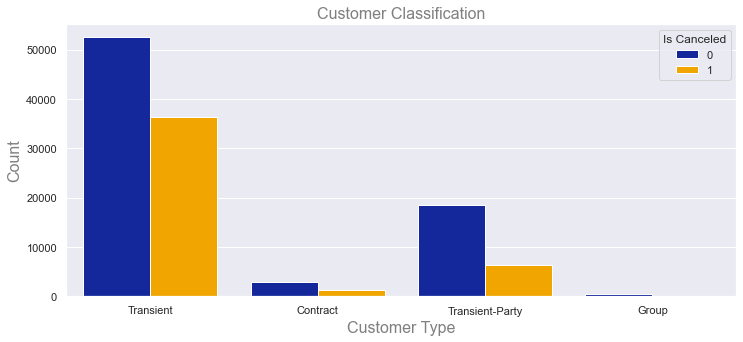

In [25]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='customer_type', hue='is_canceled', palette=["#14279B", "#F0A500"], saturation=1)
plt.title("Customer Classification", fontsize=16, color="grey")
plt.xlabel("Customer Type", fontsize=16, color="grey")
plt.ylabel("Count", fontsize=16, color="grey")
plt.legend(title="Is Canceled", loc="upper right")

plt.savefig("graphs/figure9.png")
plt.show()

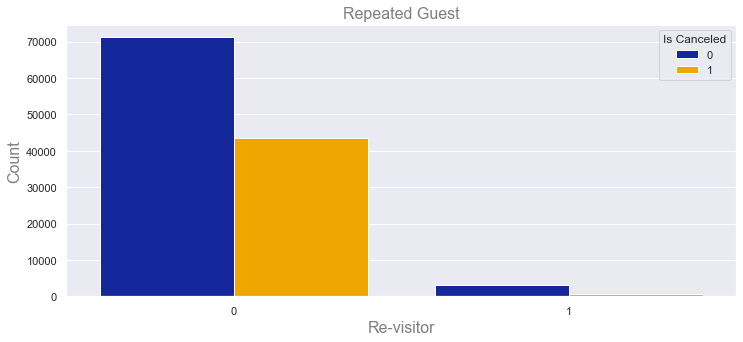

In [26]:
plt.figure(figsize=(12, 5))
sns.countplot(df["is_repeated_guest"], hue=df["is_canceled"], palette=["#14279B", "#F0A500"], saturation=1)
plt.title("Repeated Guest", fontsize=16, color="grey")
plt.xlabel("Re-visitor", fontsize=16, color="grey")
plt.ylabel("Count", fontsize=16, color="grey")
plt.legend(title="Is Canceled", loc="upper right")

plt.savefig("graphs/figure10.png")
plt.show()

In [27]:
df[['is_canceled', 'is_repeated_guest']].value_counts().to_frame('counts')

,,counts
is_canceled,is_repeated_guest,
0,0,71145
1,0,43584
0,1,3217
1,1,548


In [28]:
res_htl["total_nights"] = res_htl["stays_in_weekend_nights"] + res_htl["stays_in_week_nights"]
cty_htl["total_nights"] = cty_htl["stays_in_weekend_nights"] + cty_htl["stays_in_week_nights"]

num_nights_res = list(res_htl["total_nights"].value_counts().index)
num_bookings_res = list(res_htl["total_nights"].value_counts())
rel_bookings_res = res_htl["total_nights"].value_counts() / sum(num_bookings_res) * 100

num_nights_cty = list(cty_htl["total_nights"].value_counts().index)
num_bookings_cty = list(cty_htl["total_nights"].value_counts())
rel_bookings_cty = cty_htl["total_nights"].value_counts() / sum(num_bookings_cty) * 100

res_nights = pd.DataFrame({"hotel": "Resort hotel", "num_nights": num_nights_res, "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel", "num_nights": num_nights_cty, "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)

#### LeadTime vs ADR by Booking Status

Let's check the average price user paid with the early booking.

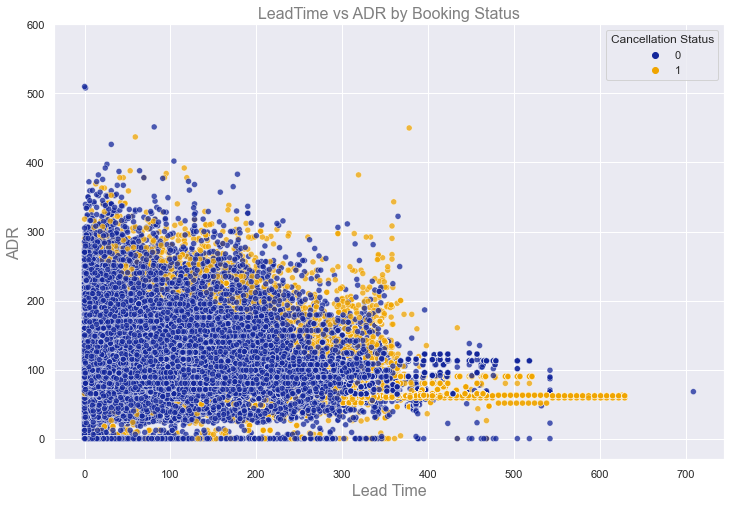

In [29]:
plt.figure(figsize=(12, 8))

sns.scatterplot("lead_time", "adr", data=df, hue="is_canceled", palette=["#14279B", "#F0A500"], alpha=0.75)

plt.ylim(-30, 600)
plt.legend(title="Cancellation Status")
plt.title("LeadTime vs ADR by Booking Status", fontsize=16, color="grey")
plt.xlabel("Lead Time", fontsize=16, color="grey")
plt.ylabel("ADR", fontsize=16, color="grey")

plt.savefig("graphs/figure11.png")
plt.show()

And we have the plot where it says that the higher `lead_time` has highest chance of getting cancelled.

#### Duration of stay

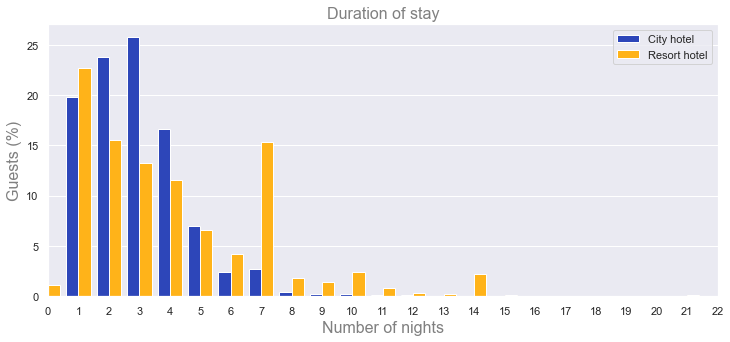

In [30]:
plt.figure(figsize=(12, 5))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data, palette=["#2D46B9", "#FFB319"], saturation=1,
            hue_order = ["City hotel", "Resort hotel"])

plt.title("Duration of stay", fontsize=16, color="grey")
plt.xlabel("Number of nights", fontsize=16, color="grey")
plt.ylabel("Guests (%)", fontsize=16, color="grey")
plt.legend(loc="upper right")

plt.xlim(0,22)
plt.savefig("graphs/figure12.png")
plt.show()

Most guests stood for 1-4 days after checkIN.

In [31]:
# drop average daily rate per person column
df.drop(['adr_pp'], axis=1, inplace=True)

### Quantative Distribution Plot

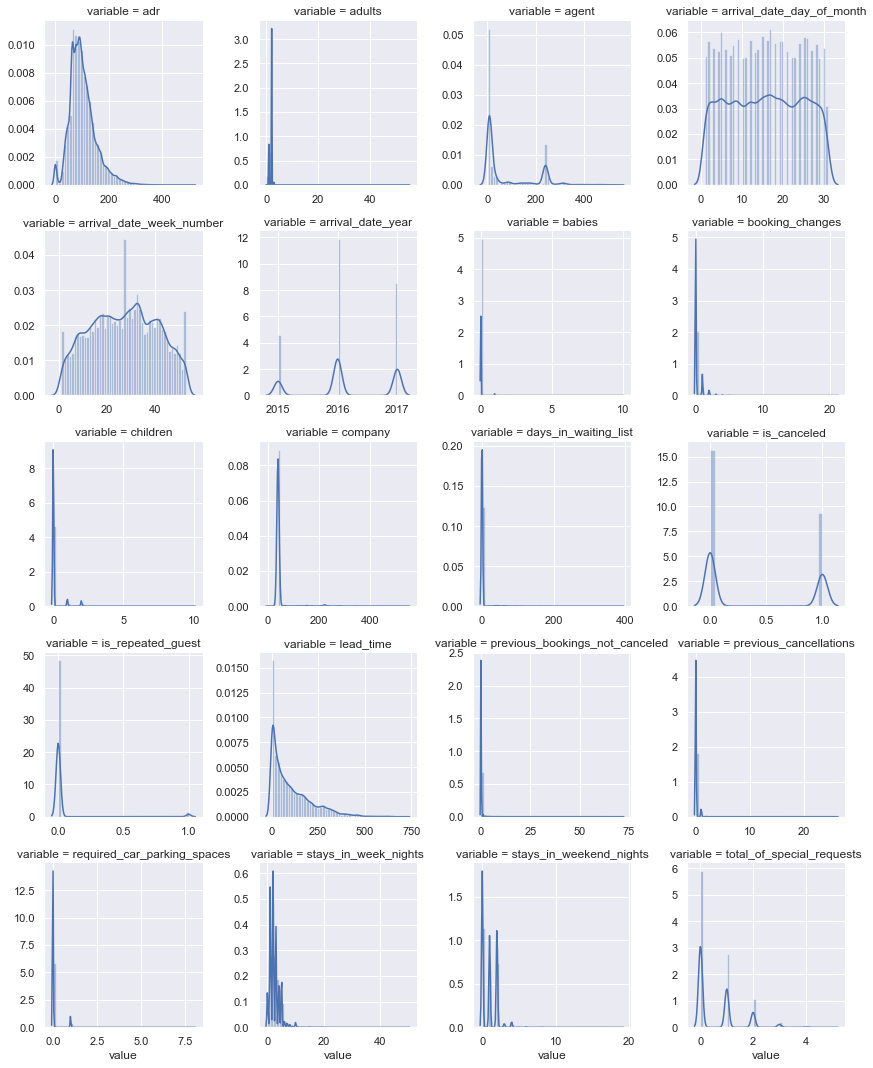

In [32]:
# Creating a distribution plot of all quantitative variable w.r.t. 'SalePrice'
melt_df = pd.melt(df, value_vars=sorted(df.select_dtypes(include=[np.number])))
sf = sns.FacetGrid(melt_df, col='variable', col_wrap=4, sharex=False, sharey=False)
sf.map(sns.distplot, 'value')
plt.savefig("graphs/figure13.png")
plt.show()

### Average Daily Rate Normalization

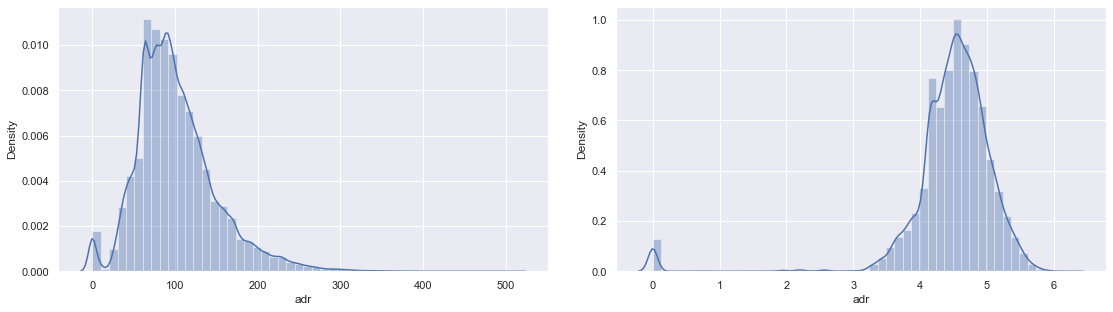

In [33]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

# Before Normalizing
sns.distplot(df['adr'], kde=True, ax = ax1)

# After Normalizing
df['adr'] = np.log1p(df.adr)
sns.distplot(df['adr'], kde=True, ax = ax2)

plt.savefig("graphs/figure14.png")
plt.show()

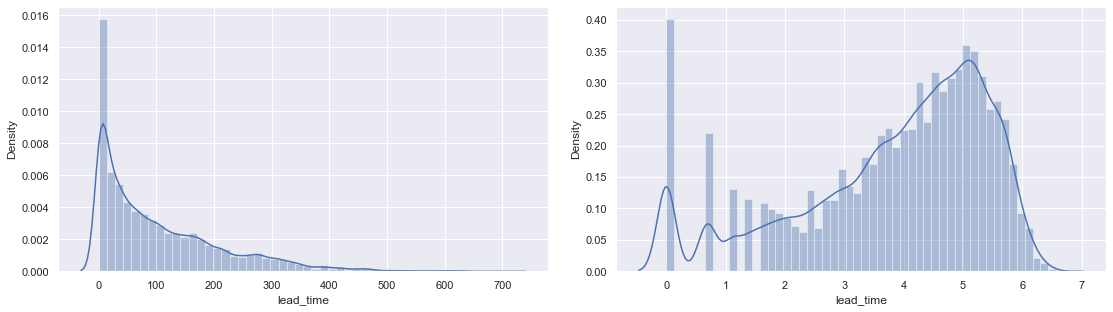

In [34]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.tight_layout(pad=3)

# Before Normalizing
sns.distplot(df['lead_time'], kde=True, ax = ax1)

# After Normalizing
df['lead_time'] = np.log1p(df.lead_time)
sns.distplot(df['lead_time'], kde=True, ax = ax2)

plt.savefig("graphs/figure15.png")
plt.show()

### Correlation

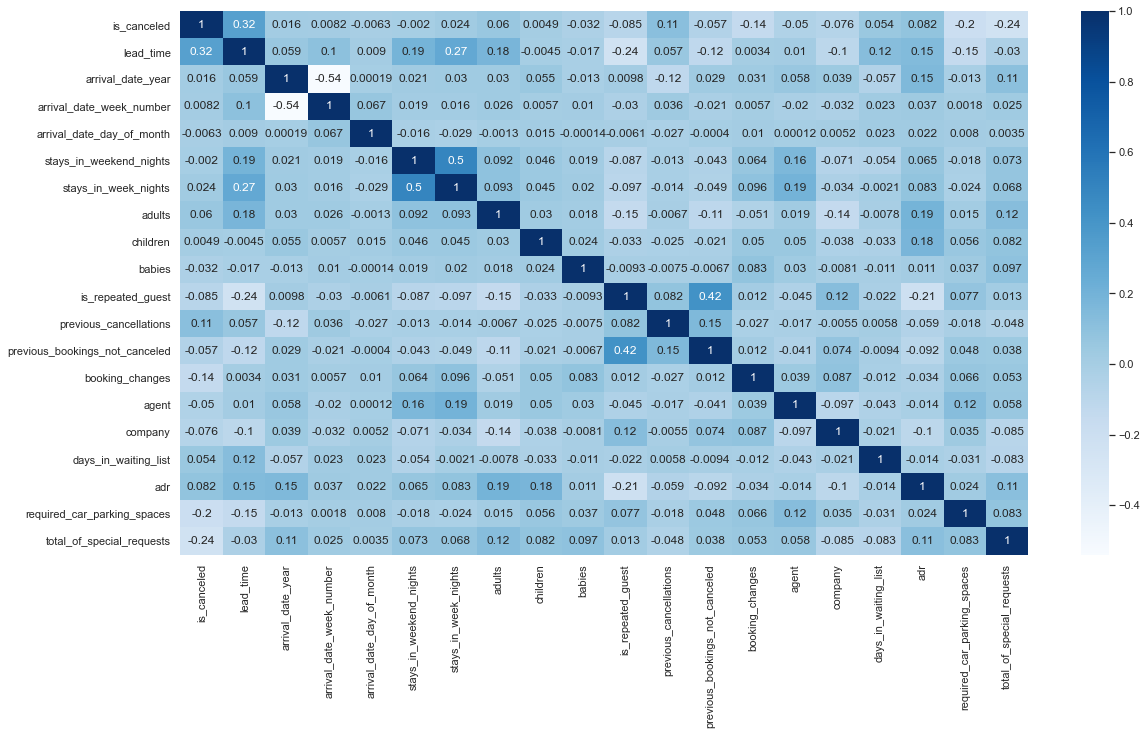

In [35]:
cormat = df.corr()

plt.figure(figsize=(19, 10))
sns.heatmap(cormat, annot=True, cmap="Blues")

plt.savefig("graphs/figure16.png")
plt.show()

In [36]:
corr_data = df.corr()["is_canceled"]
corr_data.sort_values(ascending=False)[1:]

lead_time                         0.320250
previous_cancellations            0.109853
adr                               0.081928
adults                            0.059605
days_in_waiting_list              0.053993
stays_in_week_nights              0.024480
arrival_date_year                 0.016476
arrival_date_week_number          0.008233
children                          0.004877
stays_in_weekend_nights          -0.002001
arrival_date_day_of_month        -0.006283
babies                           -0.032471
agent                            -0.049535
previous_bookings_not_canceled   -0.057411
company                          -0.075825
is_repeated_guest                -0.085017
booking_changes                  -0.144544
required_car_parking_spaces      -0.195894
total_of_special_requests        -0.235160
Name: is_canceled, dtype: float64

### Feature Engineering

Let's check if the change in room type was occured

In [37]:
df["room_change"] = (df["assigned_room_type"] == df["reserved_room_type"]).astype(str)
df["room_change"].head()

0    False
1     True
2     True
3     True
4     True
Name: room_change, dtype: object

**Filtering the feature that we are going to use for building model**

In [38]:
new_df = df[["is_canceled", "lead_time", "adults", "children", "babies", "agent",
             "is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled", "company", 
             "required_car_parking_spaces", "total_of_special_requests", "adr", "hotel", "arrival_date_month", "market_segment",
             "distribution_channel", "deposit_type", "customer_type", "room_change"]]

In [39]:
df.select_dtypes(exclude=[np.number]).columns

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date', 'arrival_month_year', 'room_change'],
      dtype='object')

Creating dummies for Categorical data

In [40]:
qual_data = new_df.select_dtypes(exclude=[np.number])
qual_dummies = pd.get_dummies(qual_data, columns=qual_data.columns, drop_first=True)
hotel_df = pd.concat([new_df, qual_dummies], axis=1)
hotel_df.drop(qual_data.columns, axis=1, inplace=True)

In [41]:
corr_data = hotel_df.corr()["is_canceled"]
corr_data.sort_values(ascending=False)[1:]

deposit_type_Non Refund           0.481254
lead_time                         0.320250
room_change_True                  0.247860
market_segment_Groups             0.222113
distribution_channel_TA/TO        0.175958
customer_type_Transient           0.133747
previous_cancellations            0.109853
adr                               0.081928
adults                            0.059605
arrival_date_month_June           0.028912
arrival_date_month_May            0.018188
arrival_date_month_September      0.012996
arrival_date_month_October        0.007076
children                          0.004877
arrival_date_month_August         0.004575
arrival_date_month_July           0.002873
distribution_channel_Undefined   -0.002238
market_segment_Online TA         -0.006517
arrival_date_month_December      -0.009825
deposit_type_Refundable          -0.011356
distribution_channel_GDS         -0.014977
arrival_date_month_February      -0.020243
market_segment_Offline TA/TO     -0.028953
arrival_dat

## Saving Data

In [42]:
hotel_df.to_csv("output/hotel_booking_cleaned_dataset.csv", index=False)

## Model Development

#### Data Modelling

In [43]:
X_data, y_data = hotel_df.drop(['is_canceled'], axis=1), hotel_df.is_canceled
X_data.shape, y_data.shape

((118494, 40), (118494,))

##### Train Test Split

In [44]:
# code to split the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, stratify=y_data, random_state=143)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((94795, 40), (94795,), (23699, 40), (23699,))

In [45]:
# Creating Balanced test data
y1_ind = list(y_test[y_test == 1].index)[:8000]
y0_ind = list(y_test[y_test == 0].index)[:8000]
x_test_1 = x_test[x_test.index.isin(y1_ind)]
y_test_1 = y_test[y_test.index.isin(y1_ind)]
x_test_0 = x_test[x_test.index.isin(y0_ind)]
y_test_0 = y_test[y_test.index.isin(y0_ind)]
x_test = x_test_1.append(x_test_0)
y_test = y_test_1.append(y_test_0)

##### Scaling Data

In [46]:
mx_scaler = MinMaxScaler()
mx_scaler = mx_scaler.fit(x_train)
x_train = mx_scaler.transform(x_train)
x_test = mx_scaler.transform(x_test)

In [47]:
def model_evaluate(model, X, y):
    """
    Returns model evaluation report.
    """
    # target prediction
    y_pred = model.predict(X)
    
    # calculating accuracy and generating evaluation report
    print(f"Accuracy : {accuracy_score(y, y_pred)}\n")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    
    labels = ['not cancelled', 'is cancelled']
    plot_text = ['TP', 'FN', 'FP', 'TN']
    group_percent = [f'{i:.2%}' for i in cm.reshape(1,-1)[0]/np.sum(cm)]
    group_count = [f'{i}' for i in cm.reshape(1, -1)[0]]
    annot = np.asarray([f'{i}\n{j}\n({k})' for i, j, k in zip(plot_text,group_percent,group_count)]).reshape(2,2)
    
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [1, 2]})
    
    # code to plot confustion matrix
    sns.heatmap(cm, annot=annot, fmt='', cmap='YlOrRd', ax=ax1)
    ax1.set(xlabel = 'Fitted Value', ylabel = 'Actual Value', xticklabels = labels, yticklabels = labels, title = 'Confusion Matrix')
    
    # code to visualize the actual vs predicted data accuracy
    sns.distplot(y, hist=False, color="r", label="Actual Value", ax=ax2)
    sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax2)

    plt.title('Actual vs Fitted Values')
    ax2.legend()
    
    fig.suptitle("Model Evaluation", fontsize=20)
    plt.show()

### Logistic Regression Model

In [48]:
# Code to train and fit data in Logistic Regression model
log_reg = LogisticRegression(class_weight={0:1,1:1.51}, max_iter=500, n_jobs=-1)
log_reg.fit(x_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 1.51}, max_iter=500, n_jobs=-1)

#####  Model Evaluation on Train Dataset

Model Evaluation on Training Set:

Accuracy : 0.7917611688380188

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     59489
           1       0.72      0.72      0.72     35306

    accuracy                           0.79     94795
   macro avg       0.78      0.78      0.78     94795
weighted avg       0.79      0.79      0.79     94795



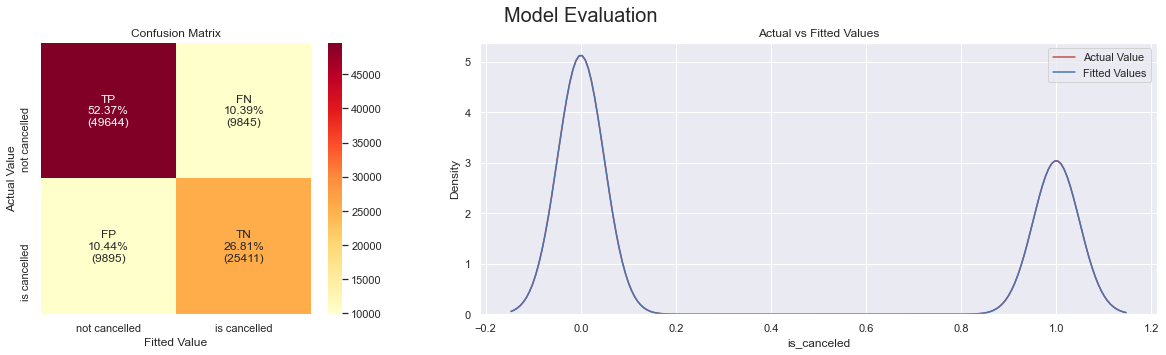

In [49]:
print("Model Evaluation on Training Set:\n")
model_evaluate(log_reg, x_train, y_train) # 63%, 36% distribution

##### Model Evaluation on Test Dataset

Model Evaluation on Test Set:

Accuracy : 0.778125

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      8000
           1       0.81      0.72      0.77      8000

    accuracy                           0.78     16000
   macro avg       0.78      0.78      0.78     16000
weighted avg       0.78      0.78      0.78     16000



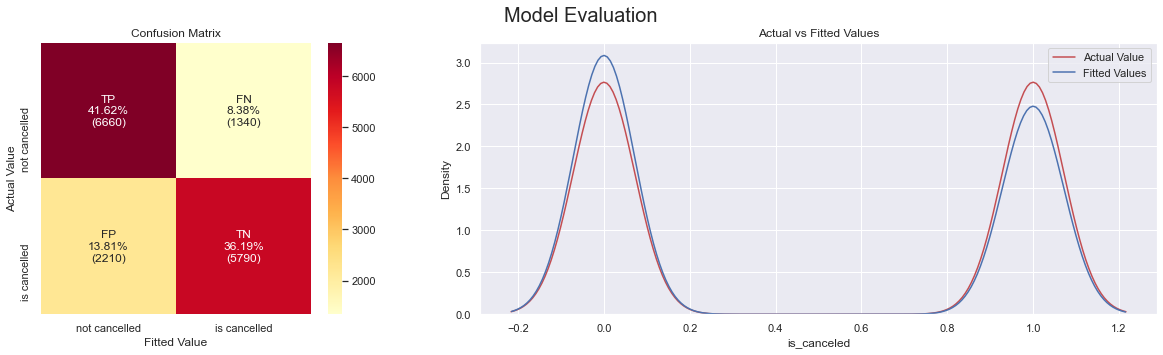

In [50]:
print("Model Evaluation on Test Set:\n")
model_evaluate(log_reg, x_test, y_test)

### Decision Tree Classifier

In [51]:
# Code to train and fit data in Decision Tree model
dct_mdl = DecisionTreeClassifier(criterion="gini", class_weight={0:0.9,1:1})
dct_mdl.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.9, 1: 1})

#####  Model Evaluation on Train Dataset

Model Evaluation on Training Set:

Accuracy : 0.9865393744395802

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59489
           1       0.98      0.99      0.98     35306

    accuracy                           0.99     94795
   macro avg       0.98      0.99      0.99     94795
weighted avg       0.99      0.99      0.99     94795



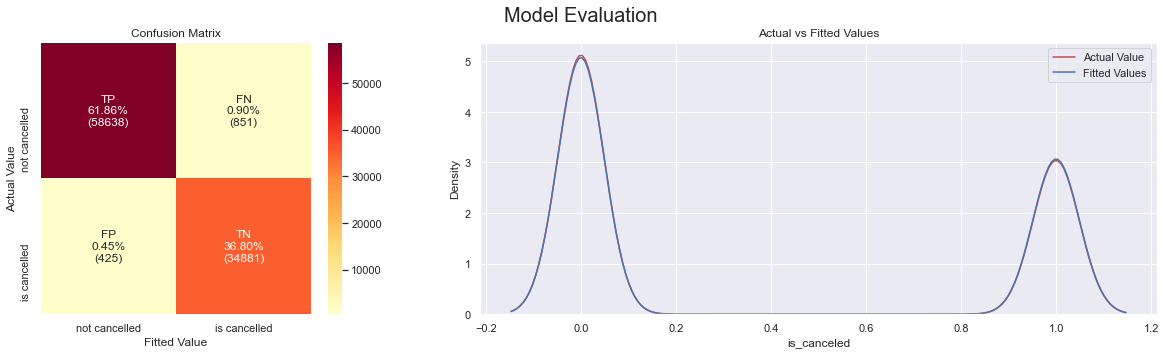

In [52]:
print("Model Evaluation on Training Set:\n")
model_evaluate(dct_mdl, x_train, y_train) # 63%, 36% distribution

#####  Model Evaluation on Test Dataset

Model Evaluation on Testing Set:

Accuracy : 0.821375

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8000
           1       0.85      0.78      0.81      8000

    accuracy                           0.82     16000
   macro avg       0.82      0.82      0.82     16000
weighted avg       0.82      0.82      0.82     16000



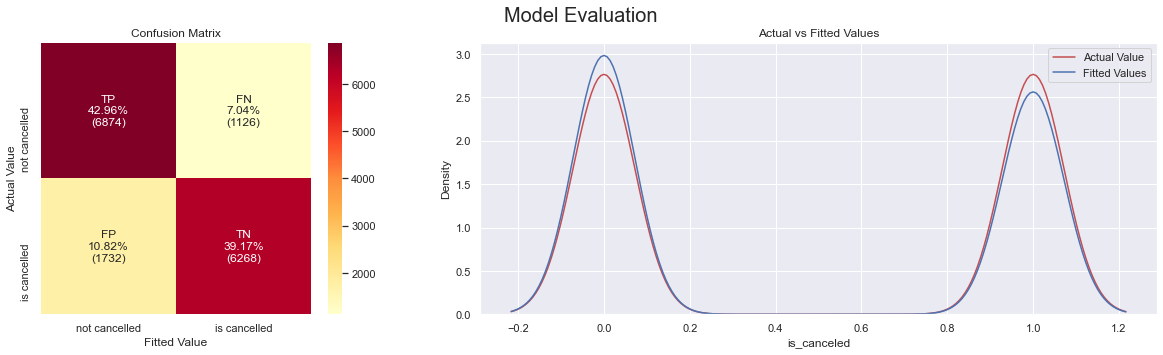

In [53]:
print("Model Evaluation on Testing Set:\n")
model_evaluate(dct_mdl, x_test, y_test)

### XGboost Classifier

In [54]:
# Code to train and fit data in XG Boost Classifier model
xgb_mdl = XGBClassifier(n_estimators=1000, learning_rate=1, n_jobs=-1)
xgb_mdl.fit(x_train, y_train)

[21:09:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#####  Model Evaluation on Train Dataset

Model Evaluation on Training Set:

Accuracy : 0.9739226752465847

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     59489
           1       0.97      0.96      0.96     35306

    accuracy                           0.97     94795
   macro avg       0.97      0.97      0.97     94795
weighted avg       0.97      0.97      0.97     94795



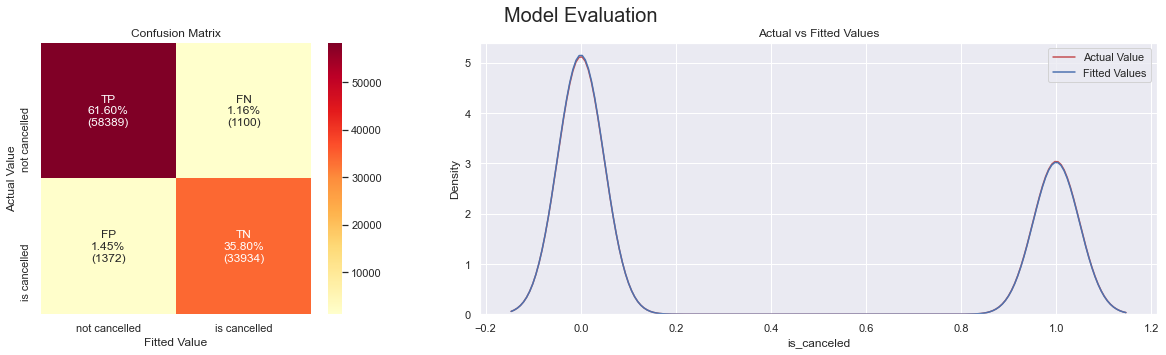

In [55]:
print("Model Evaluation on Training Set:\n")
model_evaluate(xgb_mdl, x_train, y_train)

#####  Model Evaluation on Test Dataset

Model Evaluation on Testing Set:

Accuracy : 0.8384375

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      8000
           1       0.88      0.78      0.83      8000

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000



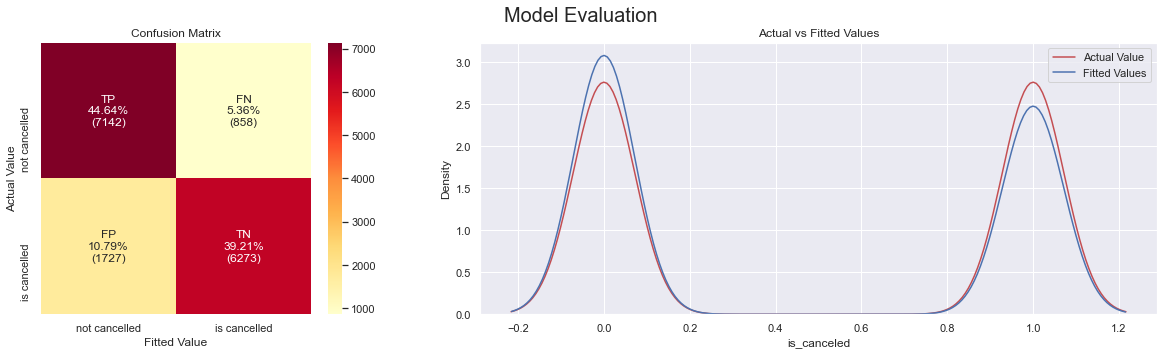

In [56]:
print("Model Evaluation on Testing Set:\n")
model_evaluate(xgb_mdl, x_test, y_test)

#### Selecting Best Model

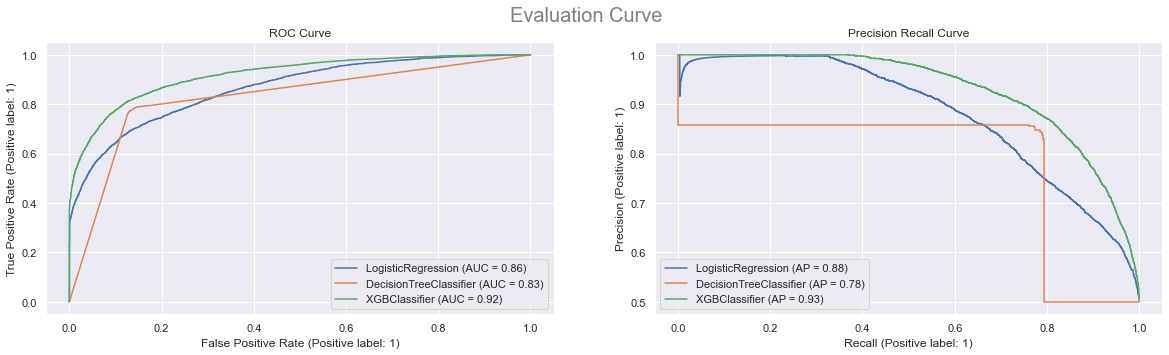

In [57]:
fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

for esitmator in [log_reg, dct_mdl, xgb_mdl]:
    plot_roc_curve(esitmator, x_test, y_test, ax=ax1)
ax1.set(title="ROC Curve")

for esitmator in [log_reg, dct_mdl, xgb_mdl]:
    plot_precision_recall_curve(esitmator, x_test, y_test, ax=ax2) 
ax2.set(title="Precision Recall Curve")

fig.suptitle("Evaluation Curve", fontsize=20, color="grey")
plt.show()

In [58]:
result = {"Algorithm":[], "f1-score (Train Set)":[], "f1-score (Test Set)":[]}
models = {"Logistic Regression":log_reg, "Decision Tree Classifier":dct_mdl, "XGBoost Classifier":xgb_mdl}

# storing model score in result dictionary
for name, estimator in models.items():
    result["Algorithm"].append(name)
    result["f1-score (Train Set)"].append(f1_score(y_train, estimator.predict(x_train)))
    result["f1-score (Test Set)"].append(f1_score(y_test, estimator.predict(x_test)))
    
result_card = pd.DataFrame(result)
result_card.set_index("Algorithm", inplace=True)
result_card.sort_values(by="f1-score (Test Set)", ascending=False)

,f1-score (Train Set),f1-score (Test Set)
Algorithm,,
XGBoost Classifier,0.964856,0.829159
Decision Tree Classifier,0.982038,0.814343
Logistic Regression,0.720246,0.765367


## Conclusion

Hotel booking cancellation was one of the main problem which was making the hotel lose it revenue and as we can see, now we have a best classification model to predict whether guest will cancel his/her booking.

<h3>Author</h3>
<h4>Akash Sharma</h4>
<div style="float:left">
  <a href="https://www.linkedin.com/in/akash-sharma-01775b14a">
    <img src="https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white" alt="LinkedIn">
  </a>
  <a href="https://discord.com/users/366283102462541865">
    <img src="https://img.shields.io/badge/Discord-7289DA?style=for-the-badge&logo=discord&logoColor=white" alt="Discord">
  </a>
  <a href="https://github.com/CosmiX-6">
    <img src="https://img.shields.io/badge/GitHub-100000?style=for-the-badge&logo=github&logoColor=white" alt="GitHub">
  </a>
</div>